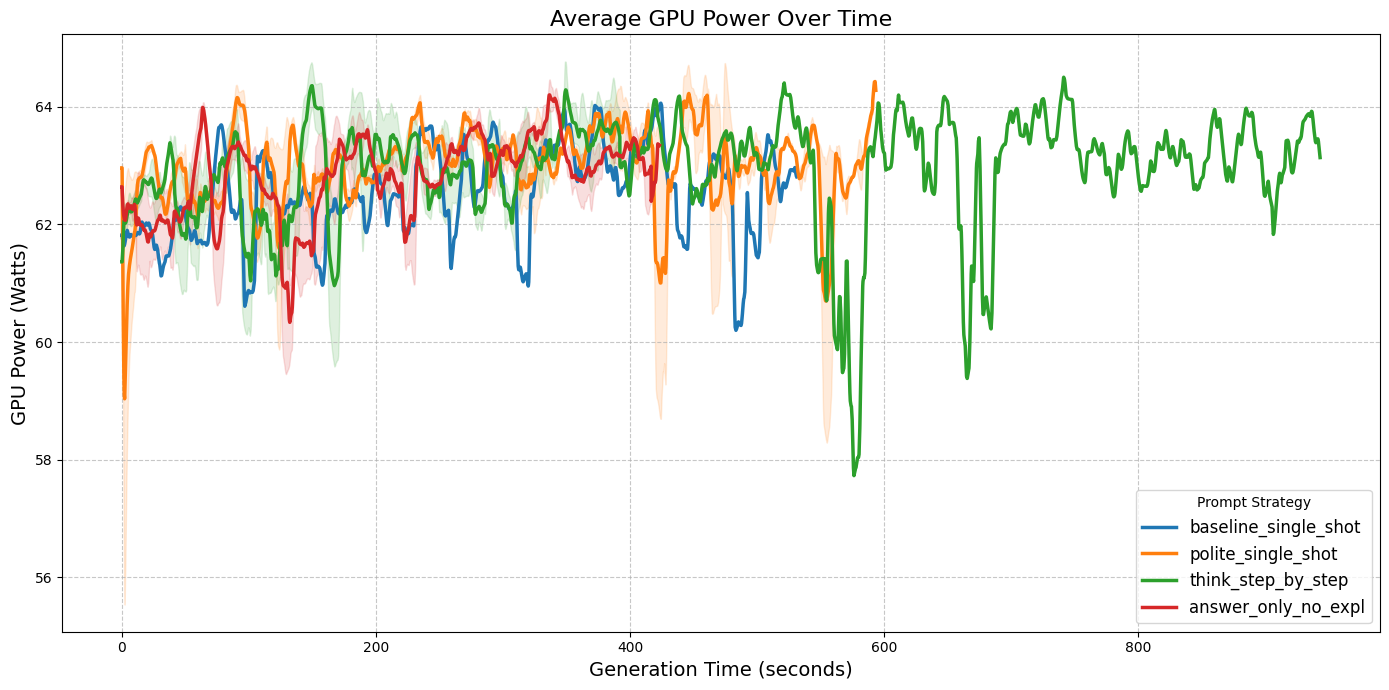

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct"
prompt_types = ['baseline_single_shot', 'polite_single_shot', 'think_step_by_step', 'answer_only_no_expl']
runs = ['r1', 'r3']

START_CUTOFF_SECONDS = 25.0
END_TRIM_SECONDS = 10.0

plt.figure(figsize=(14, 7))

for pt in prompt_types:
    df_list = []
    
    for r in runs:
        file_path = f"{base_path}/{pt}/humaneval_custom/{r}/energy.csv"
        if not os.path.exists(file_path): 
            continue
        
        df = pd.read_csv(file_path)
        df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
        
        run_end_time = df['Relative_Time_s'].max()
        
        df_zoomed = df[(df['Relative_Time_s'] >= START_CUTOFF_SECONDS) & 
                       (df['Relative_Time_s'] <= (run_end_time - END_TRIM_SECONDS))].copy()
                       
        if df_zoomed.empty: 
            continue
            
        df_zoomed['Aligned_Time_s'] = df_zoomed['Relative_Time_s'] - START_CUTOFF_SECONDS
        
        df_zoomed['GPU_Power_W'] = df_zoomed['GPU0_POWER (mWatts)'] / 1000.0
        df_zoomed['GPU_Power_Smoothed'] = df_zoomed['GPU_Power_W'].rolling(window=50, min_periods=1).mean()
        
        df_zoomed = df_zoomed.drop_duplicates(subset=['Aligned_Time_s'])
        df_list.append(df_zoomed)
        
    if not df_list: 
        continue
        
    max_time = max([d['Aligned_Time_s'].max() for d in df_list])
    
    common_time = np.arange(0, max_time, 0.1)
    
    interpolated_powers = []
    for d in df_list:
        interp_pwr = np.interp(common_time, d['Aligned_Time_s'], d['GPU_Power_Smoothed'], right=np.nan)
        interpolated_powers.append(interp_pwr)
        
    power_matrix = np.array(interpolated_powers)
    mean_power = np.nanmean(power_matrix, axis=0)
    std_power = np.nanstd(power_matrix, axis=0)
    
    line, = plt.plot(common_time, mean_power, label=pt, linewidth=2.5)
    plt.fill_between(common_time, mean_power - std_power, mean_power + std_power, 
                     color=line.get_color(), alpha=0.15)

plt.title('Average GPU Power Over Time', fontsize=16)
plt.xlabel('Generation Time (seconds)', fontsize=14)
plt.ylabel('GPU Power (Watts)', fontsize=14)
plt.legend(title='Prompt Strategy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

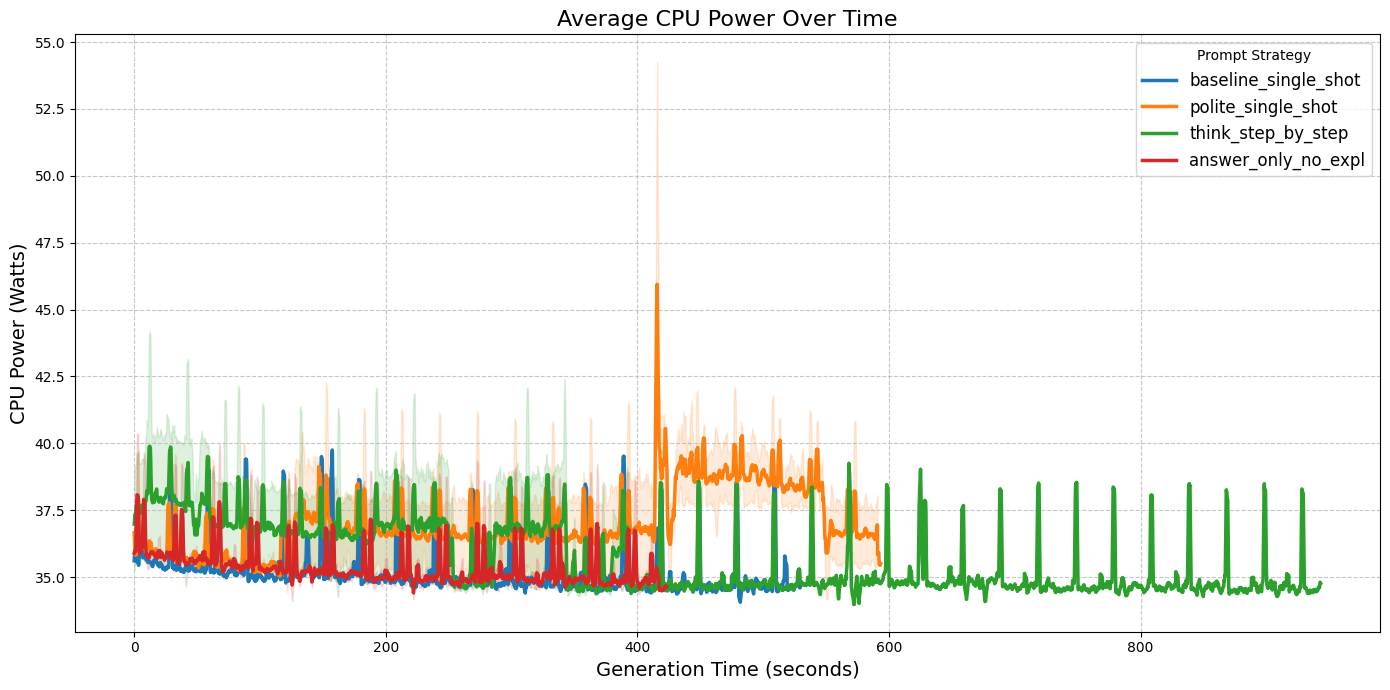

In [8]:
base_path = "../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct"
prompt_types = ['baseline_single_shot', 'polite_single_shot', 'think_step_by_step', 'answer_only_no_expl']
runs = ['r1', 'r3']

START_CUTOFF_SECONDS = 25.0
END_TRIM_SECONDS = 10.0

plt.figure(figsize=(14, 7))

for pt in prompt_types:
    df_list = []
    
    for r in runs:
        file_path = f"{base_path}/{pt}/humaneval_custom/{r}/energy.csv"
        if not os.path.exists(file_path): 
            continue
        
        df = pd.read_csv(file_path)
        df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
        
        df['CPU_Energy_Diff'] = df['CPU_ENERGY (J)'].diff()
        df['Time_Diff_s'] = df['Time'].diff() / 1000.0
        df['CPU_Power_W'] = df['CPU_Energy_Diff'] / df['Time_Diff_s']
        
        run_end_time = df['Relative_Time_s'].max()
        
        df_zoomed = df[(df['Relative_Time_s'] >= START_CUTOFF_SECONDS) & 
                       (df['Relative_Time_s'] <= (run_end_time - END_TRIM_SECONDS))].copy()
                       
        if df_zoomed.empty: 
            continue
            
        df_zoomed['Aligned_Time_s'] = df_zoomed['Relative_Time_s'] - START_CUTOFF_SECONDS
        
        df_zoomed['CPU_Power_Smoothed'] = df_zoomed['CPU_Power_W'].rolling(window=10, min_periods=1).mean()
        
        df_zoomed = df_zoomed.drop_duplicates(subset=['Aligned_Time_s'])
        df_list.append(df_zoomed)
        
    if not df_list: 
        continue
        
    max_time = max([d['Aligned_Time_s'].max() for d in df_list])
    
    common_time = np.arange(0, max_time, 0.1)
    
    interpolated_powers = []
    for d in df_list:
        interp_pwr = np.interp(common_time, d['Aligned_Time_s'], d['CPU_Power_Smoothed'], right=np.nan)
        interpolated_powers.append(interp_pwr)
        
    power_matrix = np.array(interpolated_powers)
    mean_power = np.nanmean(power_matrix, axis=0)
    std_power = np.nanstd(power_matrix, axis=0)
    
    line, = plt.plot(common_time, mean_power, label=pt, linewidth=2.5)
    plt.fill_between(common_time, mean_power - std_power, mean_power + std_power, 
                     color=line.get_color(), alpha=0.15)

plt.title('Average CPU Power Over Time', fontsize=16)
plt.xlabel('Generation Time (seconds)', fontsize=14)
plt.ylabel('CPU Power (Watts)', fontsize=14)
plt.legend(title='Prompt Strategy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

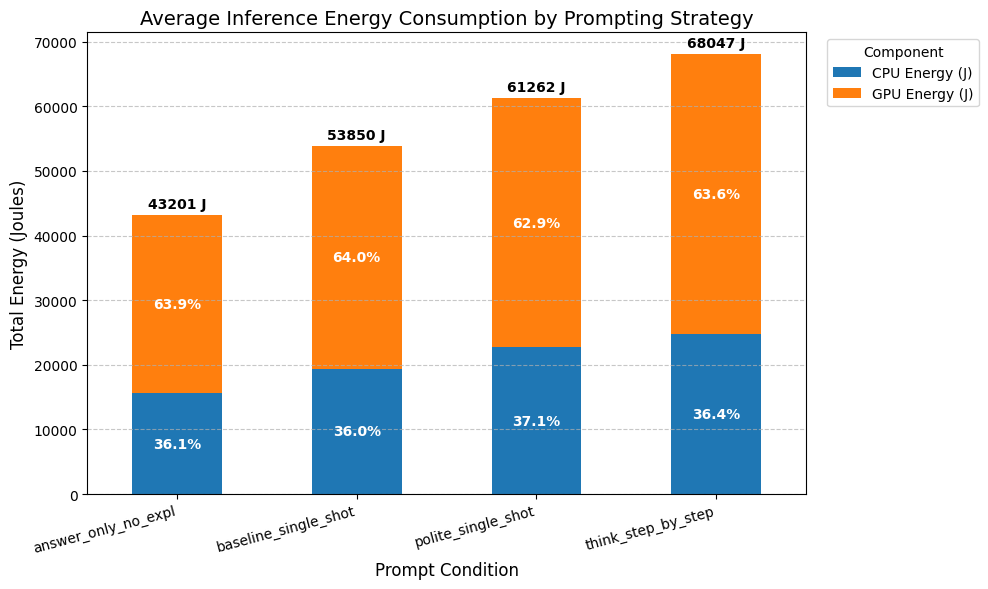

In [4]:
import glob

files = glob.glob("../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct/*/humaneval_custom/*/energy.csv")

START_CUTOFF_SECONDS = 15.0  

results = []
for f in files:
    parts = f.split(os.sep)
    condition = parts[-4] 
    run_id = parts[-2]    
    
    if run_id not in ['r1', 'r3']:
        continue
    
    df = pd.read_csv(f)
    
    df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
    
    df_filtered = df[df['Relative_Time_s'] >= START_CUTOFF_SECONDS].copy()
    if df_filtered.empty:
        continue
    
    total_cpu_energy = df_filtered['CPU_ENERGY (J)'].max() - df_filtered['CPU_ENERGY (J)'].min()
    
    df_filtered['Time_Diff_s'] = df_filtered['Time'].diff() / 1000.0
    df_filtered['GPU_Power_W'] = df_filtered['GPU0_POWER (mWatts)'] / 1000.0
    total_gpu_energy = (df_filtered['GPU_Power_W'] * df_filtered['Time_Diff_s'].fillna(0)).sum()
    
    results.append({
        'Condition': condition,
        'Run': run_id,
        'CPU Energy (J)': total_cpu_energy,
        'GPU Energy (J)': total_gpu_energy
    })

results_df = pd.DataFrame(results)

agg_df = results_df.groupby('Condition').mean(numeric_only=True).reset_index()
agg_df = agg_df.sort_values(by='GPU Energy (J)') 

ax = agg_df.set_index('Condition')[['CPU Energy (J)', 'GPU Energy (J)']].plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e']
)

plt.title('Average Inference Energy Consumption by Prompting Strategy', fontsize=14)
plt.ylabel('Total Energy (Joules)', fontsize=12)
plt.xlabel('Prompt Condition', fontsize=12)
plt.xticks(rotation=15, ha='right')

plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

totals = agg_df['CPU Energy (J)'] + agg_df['GPU Energy (J)']

cpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['CPU Energy (J)'], totals)]
ax.bar_label(ax.containers[0], labels=cpu_percentages, label_type='center', color='white', weight='bold')

gpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['GPU Energy (J)'], totals)]
ax.bar_label(ax.containers[1], labels=gpu_percentages, label_type='center', color='white', weight='bold')

ax.bar_label(ax.containers[1], fmt='%d J', label_type='edge', padding=3, weight='bold', color='black')

plt.tight_layout()
plt.show()